In [1]:
import openpyxl
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import svm
import datetime
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

import statsmodels.api as sm

import itertools
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import arima_model
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
wb1 = openpyxl.load_workbook(r"data_sheets\Книга1.xlsx")
sheet = wb1['Лист4']

In [3]:
def df_test(frame_col):
    print('Результат теста:')
    df_result = adfuller(frame_col)
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))

    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
        return True
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")
        return False

2000 2000


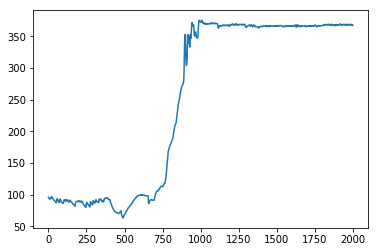

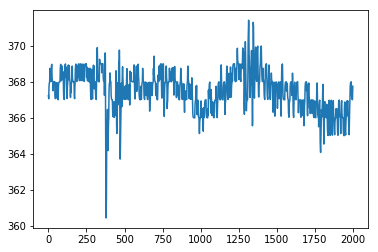

In [4]:
start = datetime.datetime.now()
timer_train = []
timer_test = []
batch_train = []
batch_test = []
n = 2000
border = 4000
num = 6000
for i in range (0, border-n):
    timer_train.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_train.append(float(sheet.cell(row = i+n, column = 2).value))
for j in range (border-n, num-n):
    timer_test.append(pd.to_datetime((sheet.cell(row = i+n, column = 8).value)))
    batch_test.append(float(sheet.cell(row = j+n, column = 2).value))
print(len(batch_train), len(batch_test))
plt.plot(batch_train)
plt.show()
plt.plot(batch_test)
plt.show()

    

Результат теста:
ADF Test Statistic : -5.836082155931208
p-value : 3.873705723389665e-07
#Lags Used : 24
Number of Observations Used : 1974
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


C:\WPy64-3720\python-3.7.2.amd64\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


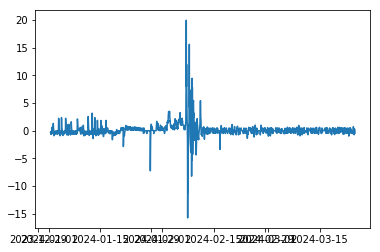

In [5]:
df1 =  pd.DataFrame(columns = ["flow1", "time"])
df1.time = timer_train
df1.flow1 = batch_train
df1_diff = df1.diff().dropna()
while(df_test(df1_diff['flow1']) != True):
    df1_diff = df1_diff.diff().dropna()
df1.index = pd.date_range(start='2024-01-01 10:00:00', periods = len(df1['flow1']), freq='h')
df1_diff.index = pd.date_range(start='2024-01-01 10:00:00', periods = len(df1_diff['flow1']), freq='h')
plt.plot(df1_diff['flow1'])

Результат теста:
ADF Test Statistic : -4.697504367665875
p-value : 8.50658934388113e-05
#Lags Used : 15
Number of Observations Used : 1984
Сильные доказательства против нулевой гипотезы, ряд является стационарным.


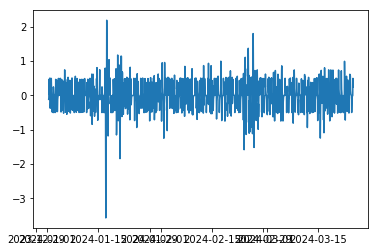

In [6]:
df2 =  pd.DataFrame(columns = ["flow1", "time"])
df2.time = timer_test
df2.flow1 = batch_test
df2_diff = df2.diff().dropna()
while(df_test(df2['flow1']) != True):
    df2_diff = df2_diff.diff().dropna()
df2.index = pd.date_range(start='2024-01-01 10:00:00', periods = len(df2['flow1']), freq='h')
df2_diff.index = pd.date_range(start='2024-01-01 10:00:00', periods = len(df2_diff['flow1']), freq='h')
plt.plot(df2_diff['flow1'])

In [7]:
model1 = SARIMAX(df1['flow1'], exog = df2['flow1'], order=(1, 2, 1), seasonal_order=(2, 1, 1, 18))
result1 = model1.fit(disp = False)

prog_start = 0

pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
forecast_values1 = pred1.predicted_mean

In [12]:
difference = np.mean(forecast_values1 - df2['flow1'])
forecast_mse1 = np.sqrt(((forecast_values1 - df2['flow1']) ** 2).mean())
print(forecast_mse1, difference)

177.57879000833563 -117.51054214179588


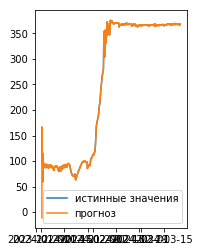

In [9]:
#forecast_mse1 = ((forecast_values1 - batch_test) ** 2).mean()
    
figure = pylab.subplot(1,2,2)
figure1 = pylab.plot(df1['flow1'], label = "истинные значения")
figure2 = pylab.plot(forecast_values1, label = "прогноз")
pylab.legend()

In [10]:
def params_optimization(dataset, dataset_test, seasonal, non_seasonal, cycles):
    for i in range (10, cycles):
        seasonal[3] = i
        try:
            model1 = SARIMAX(df1['flow1'], exog = df2['flow1'], order=(1, 1, 1), seasonal_order=(2, 1, 1, i))
            result1 = model1.fit(disp = False)
        except:
            continue
        pred1 = result1.get_prediction(start = prog_start, dynamic = False, exog = df2['flow1'])
        forecast_values1 = pred1.predicted_mean
        difference = np.mean(forecast_values1 - dataset_test)
        forecast_mse_temp = np.sqrt(((forecast_values1 - dataset_test) ** 2).mean())
        print(seasonal, difference, forecast_mse_temp)  
    return [difference, forecast_mse_temp]
    

In [11]:
params_non_seasonal = [1, 2, 1]
params_seasonal = [2, 1, 1, 10]
print(params_optimization(df1, df2['flow1'], params_seasonal, params_non_seasonal, 27))


[2, 1, 1, 10] -117.53434586137999 177.5975815254758
[2, 1, 1, 11] -117.53179586286335 177.6114172900068
[2, 1, 1, 12] -117.53474516540895 177.59846618066547
[2, 1, 1, 13] -117.53450257576777 177.59784320233894
[2, 1, 1, 14] -117.53607403111761 177.60332083449893
[2, 1, 1, 15] -117.53660710726739 177.60540537168828
[2, 1, 1, 16] -117.5367500038603 177.6050885093636
[2, 1, 1, 17] -117.53666420027615 177.60373448359968
[2, 1, 1, 18] -117.53622175629877 177.6010696242762
[2, 1, 1, 19] -117.53522962406319 177.59979835978956
[2, 1, 1, 20] -117.53415275469811 177.59667054390815
[2, 1, 1, 21] -117.53690132723294 177.60539454267573
[2, 1, 1, 22] -117.53693999574206 177.6051953882703
[2, 1, 1, 23] -117.53603684184222 177.6041247745461
[2, 1, 1, 24] -117.53851618992991 177.61010831185797
[2, 1, 1, 25] -117.53284745027702 177.5943267749084
[2, 1, 1, 26] -117.53595231076167 177.60261170743144
[-117.53595231076167, 177.60261170743144]


In [ ]:
print(params_seasonal, params_non_seasonal)